In [ ]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git
!pip3 install cma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-6jjicwxj
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-6jjicwxj
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-au9b0u4r/pydoe_e18270f7174c43b88c7debc700e66b4c
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-au9b0u4r/pydoe_e18270f7174c43b88c7debc700e66b4c
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 316 kB 10.8 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145057 sha256=cf793a9171466f26cd8a9d0314352db9e0fa4cc2cac66b892c873d01df623c40
  Stored in directory: /tmp/pip-ephem-wheel-cache-

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from pyDOE import lhs

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from benchmark.bbobbenchmarks import F12

np.random.seed(1111)

dim = 2
lb, ub = -5, 5

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

max_FEs = 2**6
verbose = False

n_samples = 30000

max_cma_iter = 20

obj_func = F12(1)

space = RealSpace([lb, ub]) * dim
samples = space.sample(n_samples)
values = obj_func(samples)

In [ ]:
opt_color, found_color, initial_color = "green", "red", "blue"

def plot(points, colors, ax=plt, outline=False, marker='o', marker_size=30):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker, s=marker_size)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker, s=marker_size)


# plot DoE, optimum, found by the BO, and global optimum on the surface of the function
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, marker='s')


# plot initial points provided to the CMA-ES and DoE, found by it, on the surface of the function
def plot_initial_found(func, samples, values, initial, found, result):
  fig, axs = plt.subplots(1, 2)
  fig.suptitle("Objective function " + func.__class__.__name__, fontsize=8)
  plot(samples, values, ax=axs[0], outline=False) # plot surface
  axs[0].set_title('Initial individual for CMA-ES')
  plot(samples, values, ax=axs[1], outline=False)
  axs[1].set_title('DoE found by CMA-ES')
  plot(initial, ["blue"] * initial.shape[0], ax=axs[0], outline=False)
  plot(found, ["yellow"] * initial.shape[0], ax=axs[1], outline=False)
  plt.show()


# plot DoE, all points used by the BO during training, global optimum, found optimum
def plot_ei_performance(func, samples, values, bo, result, marker_size=30):
  plt.suptitle("BO history", fontsize=8)
  plot(samples, values, ax=plt.gca(), outline=False) # plot surface
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=plt.gca(), marker='^', marker_size=marker_size*2)
  
  for i in range(1, len(bo.history)):
    for h in bo.history[i]:
      x, y = h
      plt.scatter(x, y, color="magenta", s=marker_size)
      plt.annotate(str(i), h)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=plt.gca(), marker='s', marker_size=marker_size)

In [ ]:
def make_optimizer(obj_func, doe):
    space = RealSpace([lb, ub], random_state=np.random.randint(1, 10000)) * dim
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1
    )

def compute_regret(doe, n=3):
  regrets, history = [], []
  best_bo, worst_bo = None, None
  for seed in range(n):
    obj_func = F12(1)
    bo = make_optimizer(obj_func, doe)
    xopt, yopt, _ = bo.run()
    cur_regret = yopt - obj_func.getfopt()
    regrets.append(cur_regret)
    if cur_regret <= min(regrets):
      best_bo = (bo, xopt, yopt, cur_regret)
    if cur_regret >= max(regrets):
      worst_bo = (bo, xopt, yopt, cur_regret)
  return np.concatenate(regrets).mean(), best_bo, worst_bo
 
def regret_function(obj_func, doe_size, n=3):
    def func(X):
        X = X.clip(lb, ub, out=X)
        doe = np.split(X, doe_size)
        regret, _, _ = compute_regret(doe, n)
        return regret
    return func

## Experiments

In [ ]:
def cma_es_experiment(obj_function, doe_size, n_test=10, individual0=None, sigma0 = ub / 3):
  if individual0 is None:
    individual0 = np.zeros(doe_size * dim) # initial individual
  
  # regret function with fixed random
  regret_func = regret_function(obj_function, doe_size, n=n_test)
  # run cma-es 
  doe_flattened, es = cma.fmin2(regret_func, individual0, sigma0, {'maxiter': max_cma_iter})
  
  # split a vector into set of points
  doe = np.split(doe_flattened, doe_size)

  return doe, es

## DoE of size [0.1 * 2**6] = 6


In [ ]:
doe_budget = 0.1
doe_size = int(doe_budget * max_FEs)

In [ ]:
individual0 = np.concatenate(lhs(2, doe_size) * 10 - 5)

### Individual0 DoE (that is used to initialize CMA-ESs)

#### DoE 

In [ ]:
individual0

array([-3.73204981,  4.66183484,  1.40269668, -0.73172872,  3.79354922,
       -4.78021722,  1.91243987,  2.76751481, -2.53628025,  0.92813154,
       -1.07219047, -3.20544504])

In [ ]:
doe_lhs = np.split(individual0, doe_size)
lhs_regret, lhs_best_bo, lhs_worst_bo = compute_regret(doe_lhs, n=100)

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likel

In [ ]:
lhs_regret

4009.729038787261

#### AF performance plot

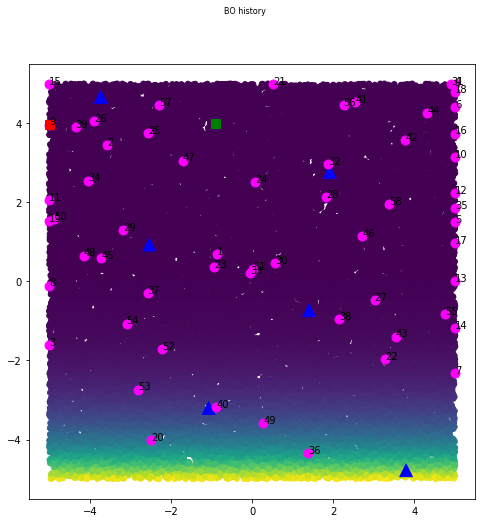

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)

lhs_bo, lhs_xopt, _, lhs_best_regret = lhs_best_bo

result = {"initial_points": np.array(doe_lhs), "found_x": lhs_xopt}
plot_ei_performance(obj_func, samples, values, lhs_bo, result, marker_size=80)

### sigma = 3.5

In [ ]:
doe35, es35 = cma_es_experiment(obj_func, doe_size, individual0=individual0, sigma0=3.5, n_test=3)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=884811, Mon Nov  7 12:36:15 2022)
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelih

In [ ]:
regret, best_bo, worst_b = compute_regret(doe35, n=100)

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likel

#### DoE

In [ ]:
doe35

[array([ 0.27029501, -0.46102512]),
 array([3.20578758, 3.28863108]),
 array([2.34351405, 1.34451271]),
 array([ 3.32312384, -3.92216242]),
 array([3.31704707, 4.01380108]),
 array([-1.09745705, -2.19664832])]

In [ ]:
regret

20.24099324198556

#### AF performance plot

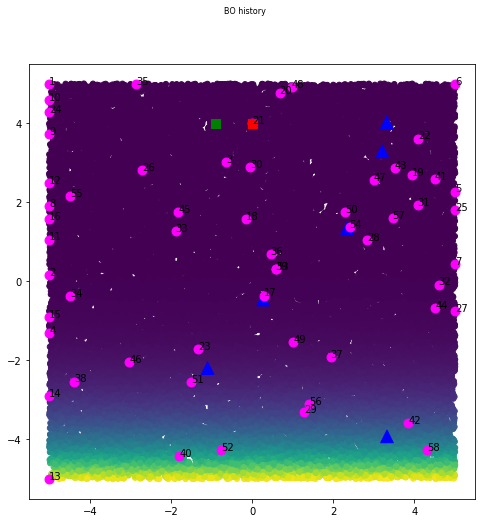

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)

bo, xopt, yopt, best_regret = best_bo

result = {"initial_points": np.array(doe35), "found_x": xopt}
plot_ei_performance(obj_func, samples, values, bo, result, marker_size=80)

In [ ]:
best_regret

array([1.16364593])

### sigma = 5 / 2


In [ ]:
doe52, es52 = cma_es_experiment(obj_func, doe_size, individual0=individual0, sigma0=5/2, n_test=3)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=979919, Mon Nov  7 16:42:30 2022)
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelih

In [ ]:
regret, best_bo, worst_bo = compute_regret(doe52, n=100)

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likel

In [ ]:
regret

11.89309725344181

#### AF performance plot

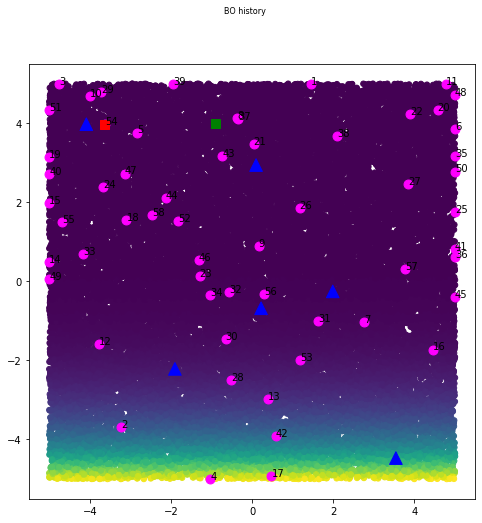

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)

bo, xopt, yopt, best_regret = best_bo

space = RealSpace([lb, ub]) * dim
# Xs for test
samples = space.sample(n_samples)
# F(X)
values = obj_func(samples)
result = {"initial_points": np.array(doe52), "found_x": xopt}
plot_ei_performance(obj_func, samples, values, bo, result, marker_size=80)

In [ ]:
best_regret

array([10.26261732])

#### DoE

In [ ]:
doe52

[array([-4.08612555,  3.97502699]),
 array([0.09629686, 2.94226919]),
 array([ 3.54220839, -4.47036462]),
 array([ 1.98597691, -0.25383723]),
 array([ 0.21996242, -0.68002939]),
 array([-1.90348716, -2.21382287])]

### sigma = 5 / 3

In [ ]:
doe53, es53 = cma_es_experiment(obj_func, doe_size, individual0=individual0, sigma0=5/3, n_test=3)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=909592, Mon Nov  7 18:28:47 2022)
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelih

In [ ]:
regret, best_bo, worst_bo = compute_regret(doe53, n=100)

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likel

In [ ]:
regret

32.24212184493896

#### AF performance plot

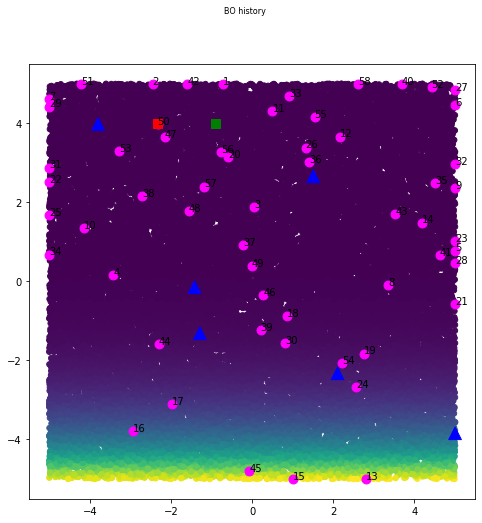

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)

bo, xopt, yopt, best_regret = best_bo

space = RealSpace([lb, ub]) * dim
# Xs for test
samples = space.sample(n_samples)
# F(X)
values = obj_func(samples)
result = {"initial_points": np.array(doe53), "found_x": xopt}
plot_ei_performance(obj_func, samples, values, bo, result, marker_size=80)

In [ ]:
best_regret

array([2.43180291])

In [ ]:
_, _, _, max_regret = worst_bo
max_regret

array([32.64371041])

#### DoE

In [ ]:
doe53

[array([-3.79556653,  3.98131129]),
 array([ 2.10476455, -2.32556861]),
 array([ 5.        , -3.84272344]),
 array([1.50530835, 2.65871811]),
 array([-1.41977592, -0.14838885]),
 array([-1.28856709, -1.3110303 ])]